<a href="https://colab.research.google.com/github/Zdestrion/ML_pvt_repo/blob/master/Copy_of_NB_GMM_iris_LC2_2020_Fuiano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering con Gaussian Mixture Model applicato al dataset iris
da esempio originale di Oscar Contreras Carrasco

In [0]:
import numpy as np

import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
from PIL import Image
from sklearn.cluster import KMeans

**Iris dataset da scikit-learn**

Consiste in 150 istanze di Iris misurate da Edgar Anderson e classificate secondo tre specie: *Iris setosa*, *Iris virginica* e *Iris versicolor*. Le quattro variabili considerate sono la lunghezza e la larghezza del sepalo e del petalo

In [0]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
#stampa efeature reative ai primi 20 eventi del dataset
X[:20]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3]])

**Parte 1: implementazione "a mano" del modello**

Gaussian density function (può essere fatto usando direttamente la funzione di numpy qui lo facciamo noi come esempio)

\begin{equation}
\large
p(\mathbf x | \mathbf\mu, \mathbf\Sigma) = \frac 1 {({2\pi})^{n/2}|\Sigma|^{1/2}}\exp\left(-\frac 1 2 (\mathbf x -\mathbf\mu)^T\mathbf\Sigma^{-1}(\mathbf x -\mathbf\mu)\right)
\end{equation}


In [0]:
def gaussian(X, mu, cov):
    n = X.shape[1]
    diff = (X - mu).T
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(diff.T, np.linalg.inv(cov)), diff))).reshape(-1, 1)

In [0]:
#test
x0 = np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]])
mu = np.mean(x0, axis=0)
cov = np.dot((x0 - mu).T, x0 - mu) / (x0.shape[0] - 1)

y = gaussian(x0, mu=mu, cov=cov)
y

array([[0.00159853],
       [0.00481869],
       [0.00276259],
       [0.0014309 ],
       [0.00143998]])

__Step 1__

Inizializzazione dei parametri $\pi_k$, $\mu_k$, e $\Sigma_k$. Come guess iniziale addestriamo un modello di k-means clustering e utilizziamo i centroidi trovati dal modello come punto di partenza ... 

In [0]:
from sklearn.cluster import KMeans
def initialize_clusters(X, n_clusters):
    clusters = []
    idx = np.arange(X.shape[0])
    
    # We use the KMeans centroids to initialise the GMM
    
    kmeans = KMeans().fit(X)
    mu_k = kmeans.cluster_centers_
    
    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': mu_k[i],
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
        
    return clusters

**Step 2 (Expectation step)**

calcolo di $\gamma(z_{nk})$ tramite l'espressione:

\begin{equation}
\large
\gamma{(z_{nk})}=\frac {\pi_k\mathcal N(\mathbf x_n| \mathbf\mu_k, \mathbf\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(\mathbf x_n| \mathbf\mu_j, \mathbf\Sigma_j)}
\end{equation}

per comodità calcoliamo il denominatore come somma di tutti i termini nel numeratore e salviamo (servirà dopo nel calcolo della likelihood) il totale nella variabile __totals__

In [0]:
def expectation_step(X, clusters):
    totals = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = (pi_k * gaussian(X, mu_k, cov_k)).astype(np.float64)
        
        for i in range(X.shape[0]):
            totals[i] += gamma_nk[i]
        
        cluster['gamma_nk'] = gamma_nk
        cluster['totals'] = totals
        
    
    for cluster in clusters:
        cluster['gamma_nk'] /= cluster['totals']

**Step 3 (Maximization step):**

calcolo:

\begin{equation}
\large
N_k=\sum_{n=1}^N\gamma({z_{nk}})
\end{equation}

e dei parametri aggiornati:

\begin{equation}
\large
\pi_k^*=\frac {N_k} N
\end{equation}

\begin{equation}
\large
\mu_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})\mathbf x_n
\end{equation}

\begin{equation}
\large
\Sigma_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})(\mathbf x_n-\mathbf\mu_k)(\mathbf x_n-\mathbf\mu_k)^T
\end{equation}

In [0]:
def maximization_step(X, clusters):
    N = float(X.shape[0])
  
    for cluster in clusters:
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((X.shape[1], X.shape[1]))
        
        N_k = np.sum(gamma_nk, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_nk * X, axis=0) / N_k
        
        for j in range(X.shape[0]):
            diff = (X[j] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[j] * np.dot(diff, diff.T)
            
        cov_k /= N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

**Definizione della log-likelihood del modello:**

\begin{equation}
\large
\ln p(\mathbf X)=\sum_{n=1}^N\ln\sum_{k=1}^K\pi_k\mathcal N(\mathbf x_n|\mu_k,\Sigma_k)
\end{equation}

poiché la seconda sommatoria corrisponde al denominatore in $\gamma$ calcolato nel __expectation_step__ e disponibile in __totals__ non dobbiamo ricalcolarlo qui ...

In [0]:
def get_likelihood(X, clusters):
    likelihood = []
    sample_likelihoods = np.log(np.array([cluster['totals'] for cluster in clusters]))
    return np.sum(sample_likelihoods), sample_likelihoods

**Algoritmo:** 
si itera la procedura per un numero fissato di epoche __n_epochs__ e si monitora il valore della log-likelihood per vedere quanto questa raggiunge un plateaux ...

In [0]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)
        
    for i, cluster in enumerate(clusters):
        scores[:, i] = np.log(cluster['gamma_nk']).reshape(-1)
        
    return clusters, likelihoods, scores, sample_likelihoods, history

**Training del modello:**

In [0]:
#scegliamo il numero di clusters e il numero di iterazioni (epoche)
n_clusters = 3
n_epochs = 50

clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, n_clusters, n_epochs)

Epoch:  1 Likelihood:  -2209.4612767535655
Epoch:  2 Likelihood:  -679.0064567960299
Epoch:  3 Likelihood:  -601.0097898588906
Epoch:  4 Likelihood:  -587.5431421018022
Epoch:  5 Likelihood:  -572.9912393252731
Epoch:  6 Likelihood:  -560.5897348594381
Epoch:  7 Likelihood:  -552.4937825156981
Epoch:  8 Likelihood:  -548.6572397639336
Epoch:  9 Likelihood:  -546.4468497275255
Epoch:  10 Likelihood:  -544.5930636984795
Epoch:  11 Likelihood:  -542.6684164564493
Epoch:  12 Likelihood:  -541.2988916694618
Epoch:  13 Likelihood:  -540.7878019363121
Epoch:  14 Likelihood:  -540.6287226839182
Epoch:  15 Likelihood:  -540.5791284485349
Epoch:  16 Likelihood:  -540.5635992422979
Epoch:  17 Likelihood:  -540.5587062040652
Epoch:  18 Likelihood:  -540.5571556847914
Epoch:  19 Likelihood:  -540.5566624474628
Epoch:  20 Likelihood:  -540.5565051807578
Epoch:  21 Likelihood:  -540.5564549716673
Epoch:  22 Likelihood:  -540.556438930369
Epoch:  23 Likelihood:  -540.5564338033164
Epoch:  24 Likelihoo

**Grafico andamento log-likelihood**

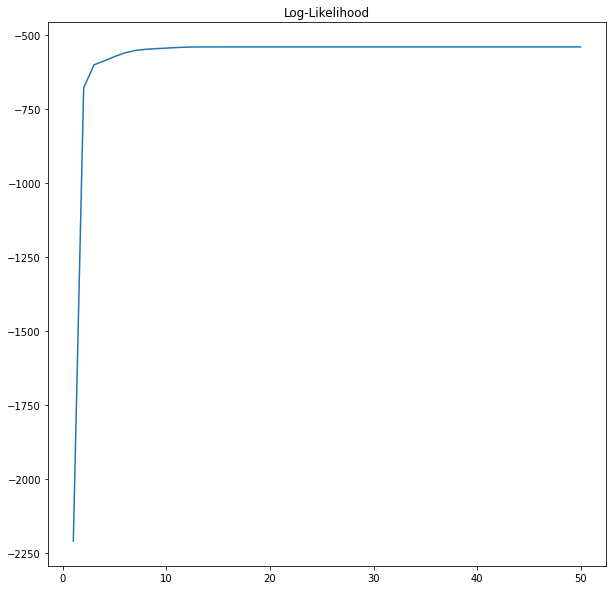

In [0]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')
plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.show()

**Visualizzazione dei clusters e dei parametri della GGM**

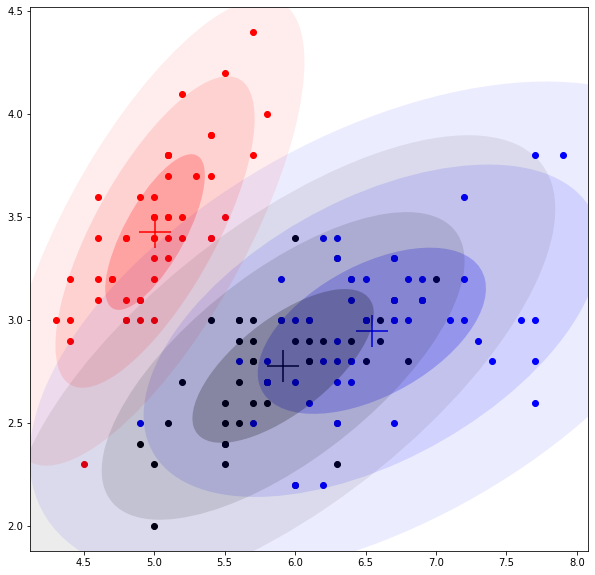

In [0]:
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(X, history, scores)

NOTA: aprendo il file __gmm.gif__  è possibile visulizzare un animazione di come la stima dei cluster migliori ad ogni iterazione.

## Implementazione usando scikit-learn ##

quella da usare in pratica ...

In [0]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_clusters, max_iter=50).fit(X)
gmm_scores = gmm.score_samples(X)
print('Means by sklearn:\n', gmm.means_)
print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
print('Scores by sklearn:\n', gmm_scores[0:20])
print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])

Means by sklearn:
 [[5.9170732  2.77804839 4.20540364 1.29848217]
 [5.006      3.428      1.462      0.246     ]
 [6.54639415 2.94946365 5.48364578 1.98726565]]
Means by our implementation:
 [[6.54454865 2.94866115 5.47955343 1.98460495]
 [5.006      3.428      1.462      0.246     ]
 [5.91496959 2.77784365 4.20155323 1.29696685]]
Scores by sklearn:
 [ 1.57050082  0.73787138  1.14436656  0.92913238  1.411028   -0.09451903
  0.05266884  1.62442195  0.27082378  0.16706624  0.83489877  0.77168582
  0.29597841 -1.79224582 -3.41557928 -2.10529279 -1.12995447  1.47503579
 -0.84612536  0.97699215]
Scores by our implementation:
 [ 1.57057947  0.73793642  1.14444614  0.92920539  1.41110417 -0.09448868
  0.05268031  1.62449505  0.27090462  0.16702226  0.83494742  0.77171947
  0.29597776 -1.79222469 -3.41562626 -2.1052825  -1.1300608   1.47509939
 -0.84608424  0.9770596 ]


## Esercizi: ##

* provare a cambiare il numero di cluster nella GMM da 1 a 10 ... la logLikelihood fornisce informazioni sul valore giusto del numeri di cluster (3)? 

* inizializzando la GMM con centroidi random invece che con i valori ottenuti da k-means si ottengono prestazioni altrettando buone?

* come si ottengono predizione di classe e probabilità di classe per la GMM in scikit-learn? Dividete il campione in 80% trainign e 20% test, addestrate la GMM con il training set e predicete label di classe e probabilità di classe per gli eventi di test ... quale è l'accuracy ottenuta? 

#Esercizio 1: Studio al variare dei clusters

Si vuole anzitutto comprendere se la log likelihood possa fornire informazioni sul corretto numero di clusters. A tal fine, utilizzando il modello implementato "a mano" si verifica cosa cambia utilizzando numero differente di clusters.

Means by our implementation:
 [[6.54454865 2.94866115 5.47955343 1.98460495]
 [5.006      3.428      1.462      0.246     ]
 [5.91496959 2.77784365 4.20155323 1.29696685]]
Scores by our implementation:
 [ 1.57057947  0.73793642  1.14444614  0.92920539  1.41110417 -0.09448868
  0.05268031  1.62449505  0.27090462  0.16702226  0.83494742  0.77171947
  0.29597776 -1.79222469 -3.41562626 -2.1052825  -1.1300608   1.47509939
 -0.84608424  0.9770596 ]


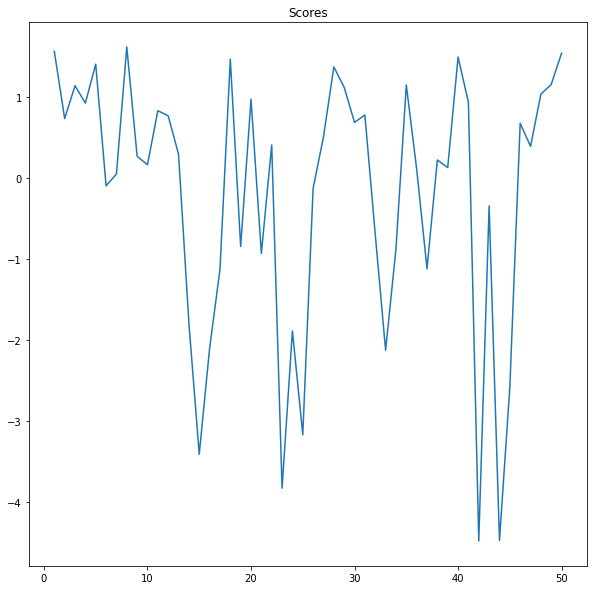

In [0]:
plt.figure(figsize=(10, 10))
plt.title('Scores')

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_clusters, max_iter=50).fit(X)
gmm_scores = gmm.score_samples(X)
plt.plot(np.arange(1, n_epochs + 1), gmm_scores[:50])

print('Means by our implementation:\n', np.array([cluster['mu_k'].tolist() for cluster in clusters]))
print('Scores by our implementation:\n', sample_likelihoods.reshape(-1)[0:20])

Epoch:  1 Likelihood:  -1392.5319209432118
Epoch:  2 Likelihood:  -379.9146301222695
Epoch:  3 Likelihood:  -379.9146301222695
Epoch:  4 Likelihood:  -379.9146301222695
Epoch:  5 Likelihood:  -379.9146301222695
Epoch:  6 Likelihood:  -379.9146301222695
Epoch:  7 Likelihood:  -379.9146301222695
Epoch:  8 Likelihood:  -379.9146301222695
Epoch:  9 Likelihood:  -379.9146301222695
Epoch:  10 Likelihood:  -379.9146301222695
Epoch:  11 Likelihood:  -379.9146301222695
Epoch:  12 Likelihood:  -379.9146301222695
Epoch:  13 Likelihood:  -379.9146301222695
Epoch:  14 Likelihood:  -379.9146301222695
Epoch:  15 Likelihood:  -379.9146301222695
Epoch:  16 Likelihood:  -379.9146301222695
Epoch:  17 Likelihood:  -379.9146301222695
Epoch:  18 Likelihood:  -379.9146301222695
Epoch:  19 Likelihood:  -379.9146301222695
Epoch:  20 Likelihood:  -379.9146301222695
Epoch:  21 Likelihood:  -379.9146301222695
Epoch:  22 Likelihood:  -379.9146301222695
Epoch:  23 Likelihood:  -379.9146301222695
Epoch:  24 Likeliho

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


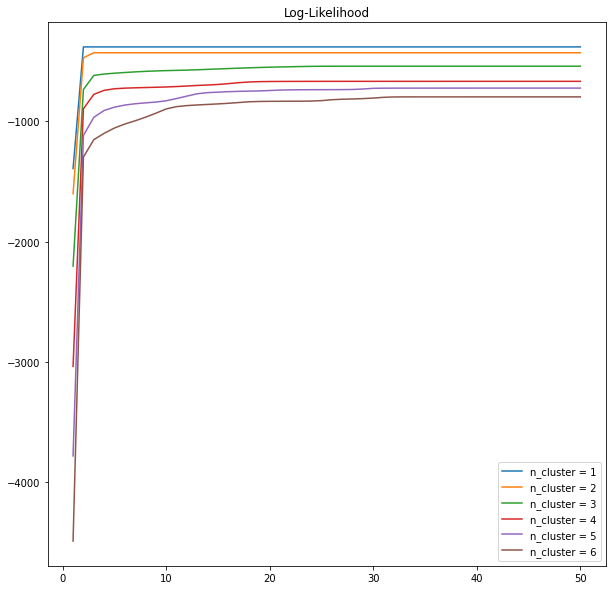

In [0]:
plt.figure(figsize=(10, 10))
plt.title('Log-Likelihood')

for n_index in range(1,7,1):
  lab = 'n_cluster = '+str(n_index)
  clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(X, n_index, n_epochs)
  plt.plot(np.arange(1, n_epochs + 1), likelihoods,label=lab)
  plt.legend(loc=0)

plt.show()

E' possibile evincere a colpo d'occhio come né l'andamento degli scores né il confronto tra log likelihood ottenute con un numero differente di clusters possano dare informazioni su quale di questi ultimi sia più corretto utilizzare. Dal plot soprastante, infatti, si nota solo un abbassamento progressivo del plateau con la crescita progressiva del numero di clusters. 

#Esercizio 2: inizializzazione con centroidi random

Per comodità di trattazione si utilizza da adesso in poi la funzione GaussianMixture di scikit-learn. Si vuole comprendere, al fine del problema trattato, se convenga inizializzare i centroidi randomicamente o attraverso k-means (ciò è possibile semplicemente cambiando un parametro della funzione sopracitata). Si procede dunque alla verifica. 


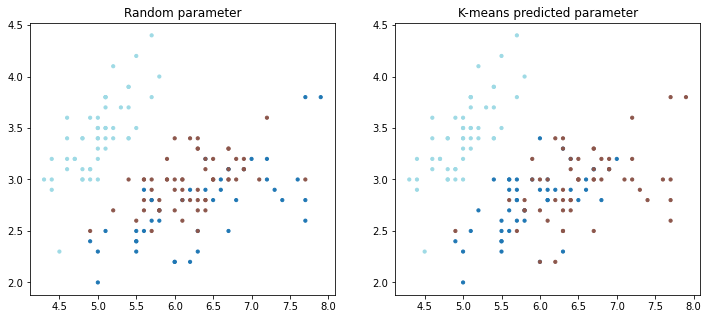

In [0]:
from sklearn.mixture import GaussianMixture
from sklearn import metrics
import matplotlib.pyplot as plt

Y = iris.target

plt.figure(figsize=(12,5))

gmm = GaussianMixture(n_components=n_clusters, max_iter=50, init_params='random')
gmm.fit(X)
gmm_scores = gmm.score_samples(X)
gmm_pred = gmm.predict(X)

gmm_new = GaussianMixture(n_components=n_clusters, max_iter=50, init_params='kmeans')
gmm_new.fit(X)
gmm_scores_new = gmm_new.score_samples(X)
gmm_pred_new = gmm_new.predict(X)

ax1 = plt.subplot(1, 2, 1)
ax1 = plt.title('Random parameter')
ax1 = plt.scatter(X[:, 0], X[:, 1], s=10, c=gmm_pred,cmap = 'tab20')
ax2 = plt.subplot(1, 2, 2)
ax2 = plt.title('K-means predicted parameter')
ax2 = plt.scatter(X[:, 0], X[:, 1], s=10, c=gmm_pred_new,cmap = 'tab20')


In [0]:
k_means_acc = metrics.adjusted_rand_score(Y, gmm_pred_new)
random_acc = metrics.adjusted_rand_score(Y, gmm_pred)
print ("Accuracy with k-means selected centroids: %.4f"%k_means_acc, "\nAccuracy with random selected centroids: %.4f"%random_acc)

Accuracy with k-means selected centroids: 0.9039 
Accuracy with random selected centroids: 0.5688


Re-runnando diverse volte il programma, come ci si aspettava, l'accuracy con i centroidi selezionati randomicamente è molto instabile, a differenza di quella ottenuta dai centroidi predetti con k-means, molto stabile. Quest'ultima, basata sull'algoritmo predittivo k-means, risulta inoltre sempre maggiore dell'accuracy data da centroidi random. <br />
Si preferirà dunque, almeno per questo tipo di problema, utilizzare una inizializzazione k-means. 

#Esercizio 3: Implementazione vera e propria di GMM con test di accuracy
Si opera, infine, un'implementazione completa, utilizzando tutto ciò che è stato appreso fin'ora sull'utilizzo più adeguato di GMM in questo tipo di problema. Si splitterà dunque il dataset in train e test set e si verificherà l'accuracy di previsione del modello. 

In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
train_to_test_ratio=0.8 # training samples
n_clusters=3

X = iris.data
Y = iris.target

In [0]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)
gmm = GaussianMixture(n_components=n_clusters, max_iter=50, init_params='kmeans')

gmm.fit(X_train)
gmm_scores = gmm.score_samples(X_train)

gmm_pred = gmm.predict(X_train)

gmm_pred_test = gmm.predict(X_test)

data=pd.DataFrame(X_train)
data['true labels']=Y_train
data['predicted labels']=gmm_pred

data_test=pd.DataFrame(X_test)
data_test['true labels']=Y_test
data_test['predicted labels']=gmm_pred_test


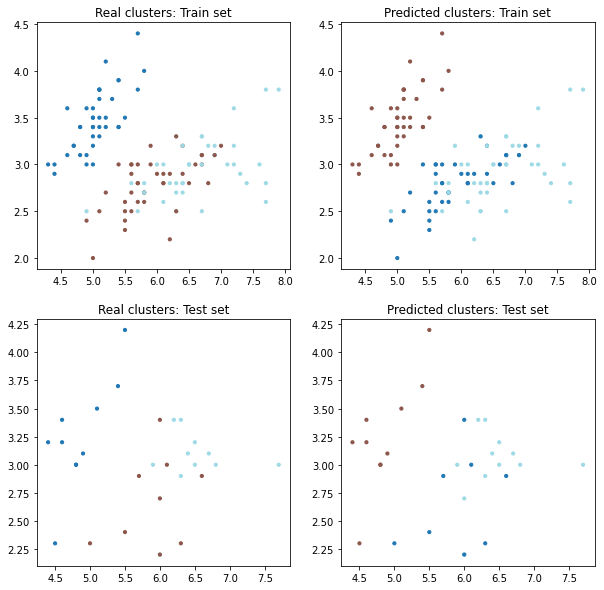

In [0]:
plt.close()

plt.figure(figsize=(10,10))
ax1 = plt.subplot(2, 2, 1)
ax1 = plt.title('Real clusters: Train set')
ax1 = plt.scatter(X_train[:, 0], X_train[:, 1], s=10, c=Y_train,cmap = 'tab20')
ax2 = plt.subplot(2, 2, 2)
ax2 = plt.title('Predicted clusters: Train set')
ax2 = plt.scatter(X_train[:, 0], X_train[:, 1], s=10, c=gmm_pred,cmap = 'tab20')
ax3 = plt.subplot(2, 2, 3)
ax3 = plt.title('Real clusters: Test set')
ax3 = plt.scatter(X_test[:, 0], X_test[:, 1], s=10, c=Y_test,cmap = 'tab20')
ax4 = plt.subplot(2, 2, 4)
ax4 = plt.title('Predicted clusters: Test set')
ax4 = plt.scatter(X_test[:, 0], X_test[:, 1], s=10, c=gmm_pred_test,cmap = 'tab20')

plt.show()

Si nota come i cluster reali siano quasi identici a quelli reali. Per un confronto preciso valutiamo l'accuracy sui due set.

In [0]:
train_acc = metrics.adjusted_rand_score(Y_train, gmm_pred)
test_acc = metrics.adjusted_rand_score(Y_test, gmm_pred_test)
print ("Accuracy on the train set: %.4f"%train_acc, "\nAccuracy on the test set: %.4f"%test_acc)

Accuracy on the train set: 0.9035 
Accuracy on the test set: 0.8990


Per la limitatezza dei dati in input, i valori di accuracy risultanti risultano più che apprezzabili. Ci si ritiene soddisfatti dell'algoritmo. <br /> <br />
N.B. Si riporta di seguito il modo per estrapolare dal modello la probabilità di appartenenza ad ogni classe per il singolo dato. Questa funzionalità può rivelarsi utile nel caso di problemi a molti cluster, nei quali le probabilità di assegnazione a due o più cluster possono essere simili tra loro.

In [0]:
#We show the last five values just as a demonstration of the predict_proba functionality
gmm_pred_proba = gmm.predict_proba(X_train)
gmm_pred_proba_test = gmm.predict_proba(X_test)
print("Probability for each cluster, train set:\n",gmm_pred_proba[-5:],"\n\nProbability for each cluster, test set:\n",gmm_pred_proba_test[-5:])


Probability for each cluster, train set:
 [[9.88949964e-001 3.54468699e-054 1.10500358e-002]
 [9.99783837e-001 7.84922905e-030 2.16162770e-004]
 [1.76035347e-003 3.25386590e-146 9.98239647e-001]
 [1.02186793e-040 1.00000000e+000 2.75718587e-029]
 [7.35731953e-011 1.20759476e-112 1.00000000e+000]] 

Probability for each cluster, test set:
 [[1.18096959e-005 8.00068674e-117 9.99988190e-001]
 [9.59549575e-001 5.55447345e-070 4.04504245e-002]
 [5.46435985e-034 1.00000000e+000 1.40166287e-024]
 [2.50980416e-031 1.00000000e+000 7.21573394e-025]
 [9.97574971e-001 1.81618411e-074 2.42502927e-003]]
